# Background Information

In the data, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
#K.tensorflow_backend._get_available_gpus()

In [2]:
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.1.0
tf.keras.__version__ is: 2.2.4-tf


# Import Data

## Import and preliminarily understand the training dataset

There are total 1804874 rows and 44columns in the dataset
train.csv - the training set, which includes toxicity labels and subgroups


In [3]:
train_df = pd.read_csv(r'D:\Springboard\Github\Data-NLP-Toxic Classification\train.csv', index_col='id',engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [13]:
train_df.shape

(1804874, 44)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [16]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [17]:
# understand the missing value in the dataset 
train_df.isna().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

## Import and preliminarily understand the testing dataset

test.csv - the test set, which does not include toxicity labels or subgroups

In [4]:
test_df = pd.read_csv(r'D:\Springboard\Github\Data-NLP-Toxic Classification\test.csv',index_col='id',engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97320 entries, 7097320 to 7194639
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  97320 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [19]:
test_df.describe()

,comment_text
count,97320
unique,96862
top,Well said.
freq,12


In [ ]:
# understand the missing value in training dataset 

In [20]:
test_df.isnull().sum()

comment_text    0
dtype: int64

# Exploratory Data Analysis 

## Understand the target varibale in training dataset 

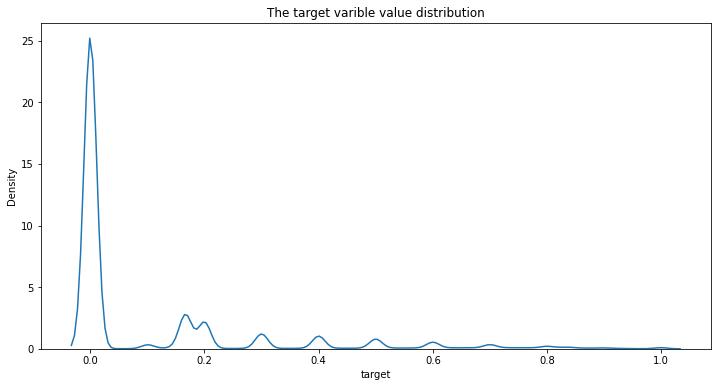

In [23]:
# plot the distribution of target varible and it show that most of the comments in the dataset are non-toxi(<0.5). 
plt.figure(figsize=(12,6))
plt.title("The target varible value distribution")
sns.distplot(train_df['target'],kde=True, hist=False, bins=240, label='target')
plt.show()

In [29]:
# the value <0.5 is non_toxic else it is toxic, then encoding them into two categories 
train_df['temp_target'] =['non_toxic' if i <0.5 else 'toxic'for i in train_df['target'] ] 

In [30]:
# There are around 92% non-toxic comments and 8% toxic comments
train_df['temp_target'].value_counts(normalize=True)

non_toxic    0.920031
toxic        0.079969
Name: temp_target, dtype: float64

<AxesSubplot:>

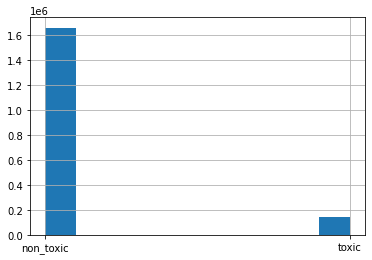

In [31]:
# plot histgram for temp_target
train_df['temp_target'].hist()

## Understand the features in the training dataset 

- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [32]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

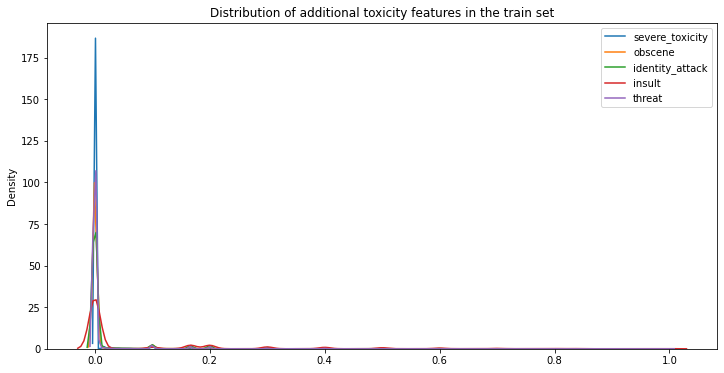

In [33]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

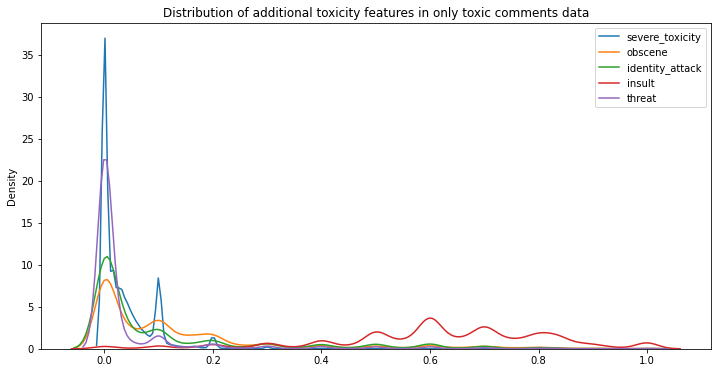

In [34]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

##### Compared with other kinds of comments among toxic comments, insulting comment appears most frequently. 

In [35]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

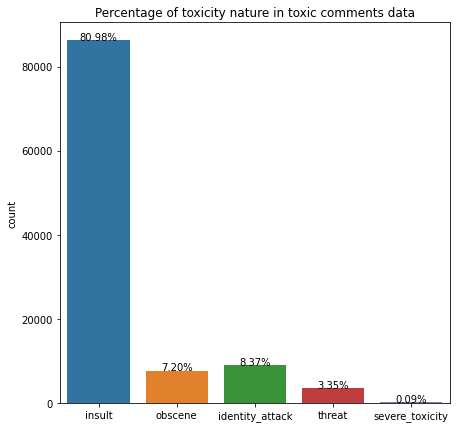

In [36]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

##### There are around 8% toxic comments in the trainig dataset. In these 8%, there are 80.98% are insult comments, 7.2% are obscene comments, 8.37% identity_attack, 3.35% threat comments and only 0.09 severe_toxicity comments. 

## Identity Attributes Analysis 

a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.

- male
- female
- transgender
- other_gender
- heterosexual
- homosexual_gay_or_lesbian
- bisexual
- other_sexual_orientation
- christian
- jewish
- muslim
- hindu
- buddhist
- atheist
- other_religion
- black
- white
- asian
- latino
- other_race_or_ethnicity
- physical_disability
- intellectual_or_learning_disability
- psychiatric_or_mental_illness
- other_disability
Note that the data contains different comments that can have the exact same text. Different comments that have the same text may have been labeled with different targets or subgroups.
The information provide by https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data 

In [37]:
train_df.columns

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'temp_target'],
      dtype='object')

In [38]:
temp = train_df.dropna(axis = 0, how = 'any')

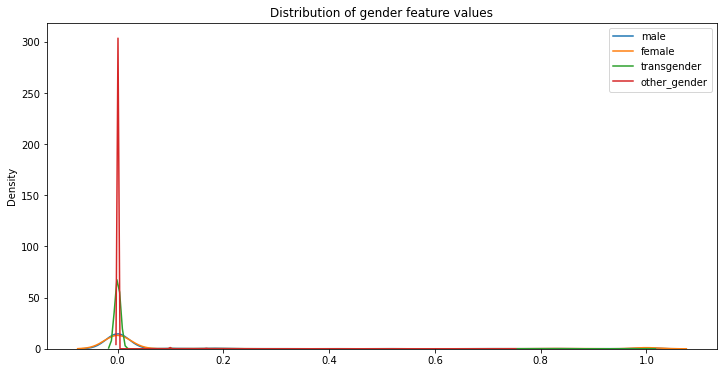

In [39]:
# Gender related variables
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

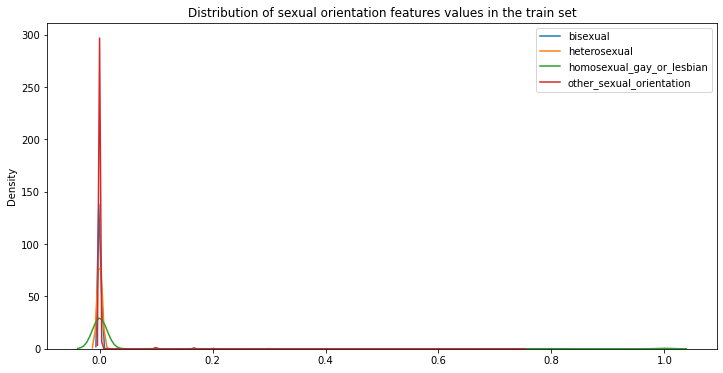

In [40]:
# sex oriented related varibles 
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

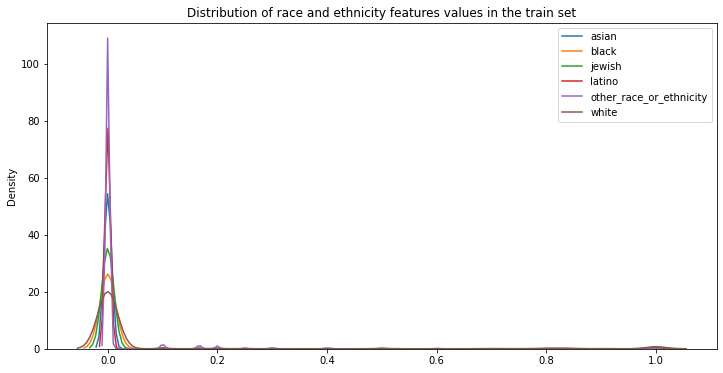

In [41]:
# original related varibles 
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

In [6]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

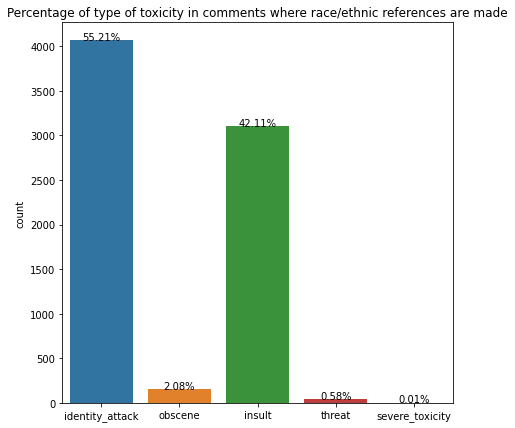

In [7]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

######  The religion words involving black, asians, jewish,latino, white etc are mainly focused on identity_attack and insult. 

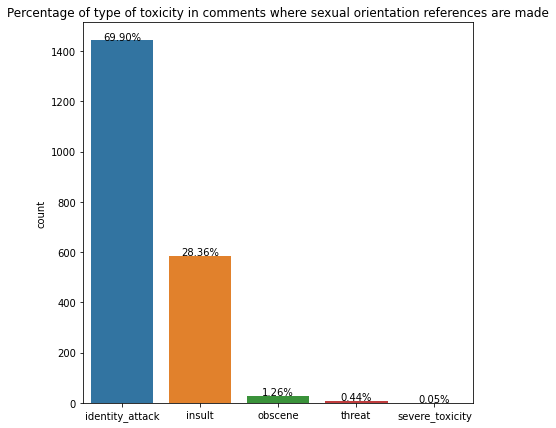

In [8]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

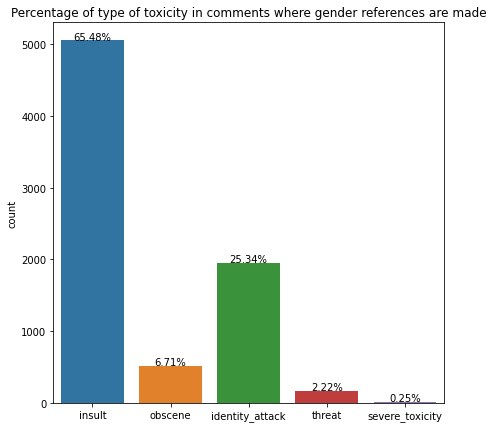

In [9]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

######  The words involving sexual_orientation  and gender oriented words are appeared the similar passion  as the race_or_ethnicity category, which mainly focus on identity_attack and insult. 

## Variables generated by users feedback:
- funny
- sad
- wow
- likes
- disagree

the dataset provides metadata from Jigsaw's annotation: toxicity_annotator_count and identity_annotator_count, and metadata from Civil Comments: created_date, publication_id, parent_id, article_id, rating, funny, wow, sad, likes, disagree. 

In [15]:
train_df.columns 

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [16]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

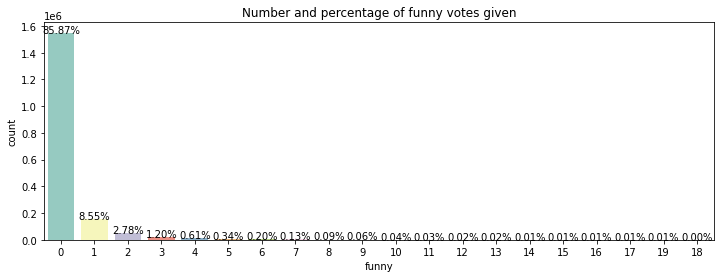

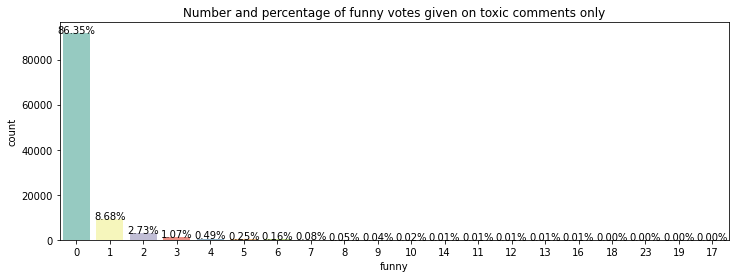

In [17]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

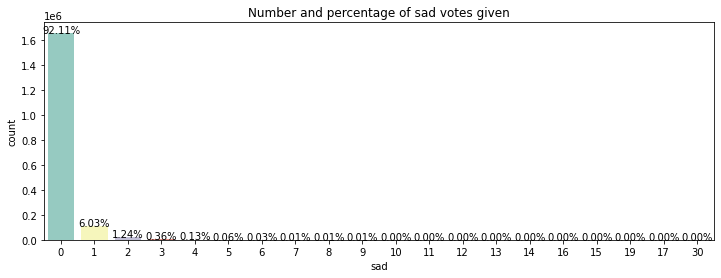

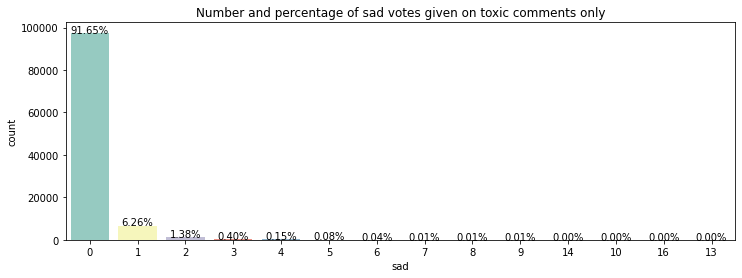

In [18]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

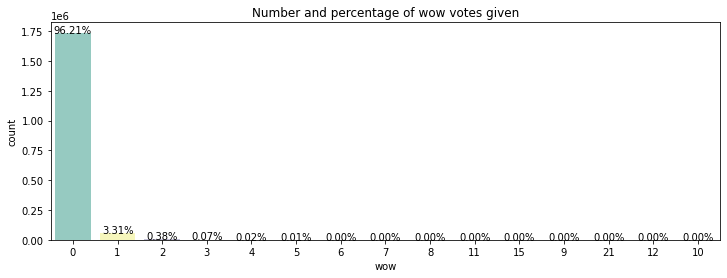

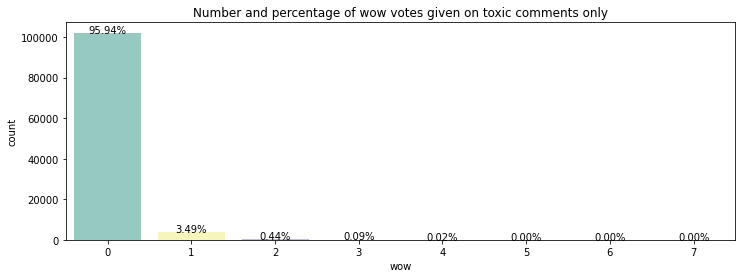

In [19]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

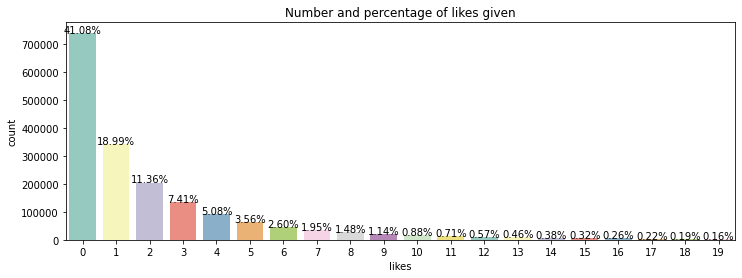

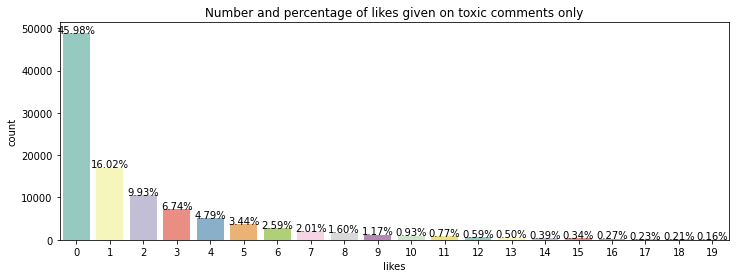

In [20]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

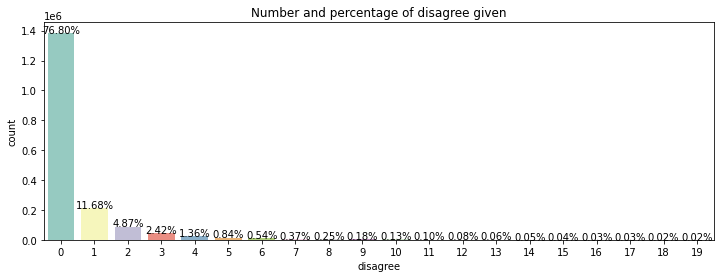

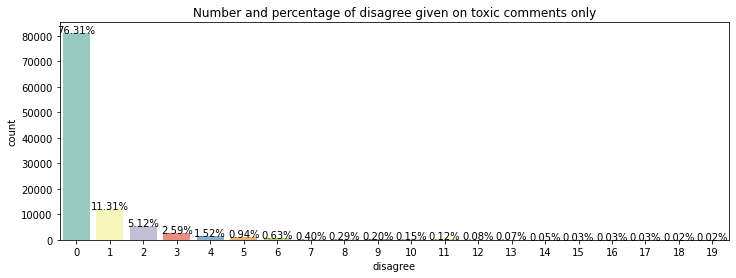

In [21]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

## Comment_text Feature

In [28]:
from wordcloud import WordCloud, STOPWORDS

In [29]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

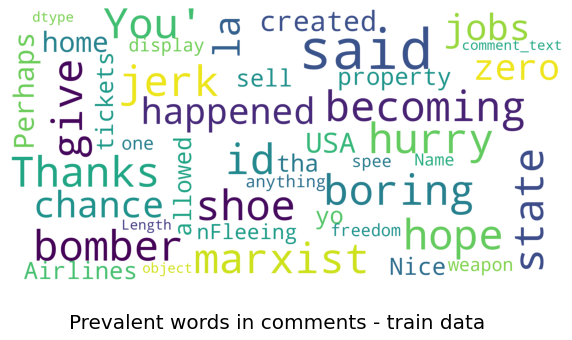

In [30]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

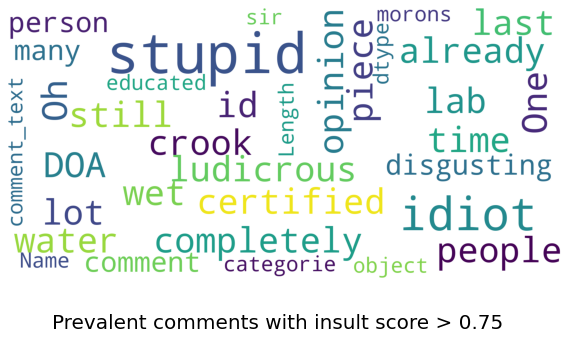

In [31]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

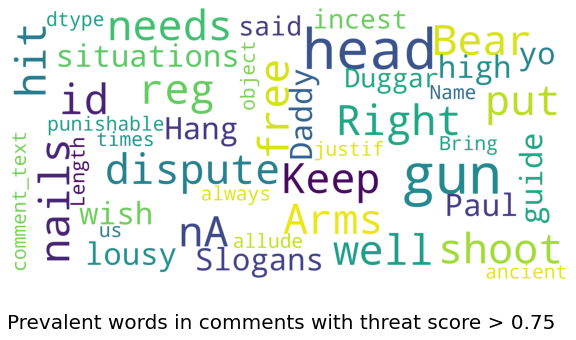

In [32]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

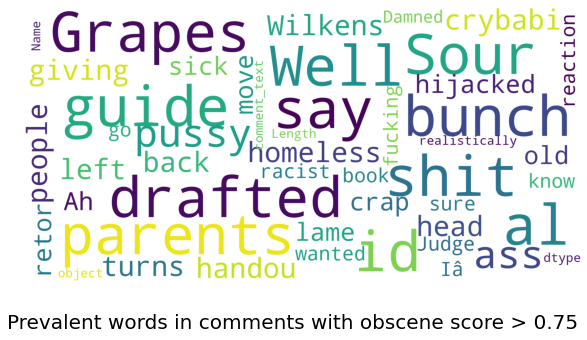

In [33]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

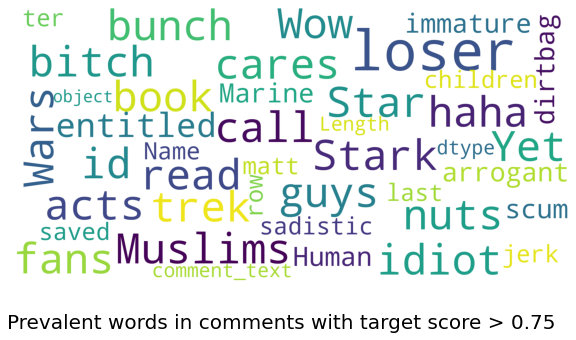

In [34]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

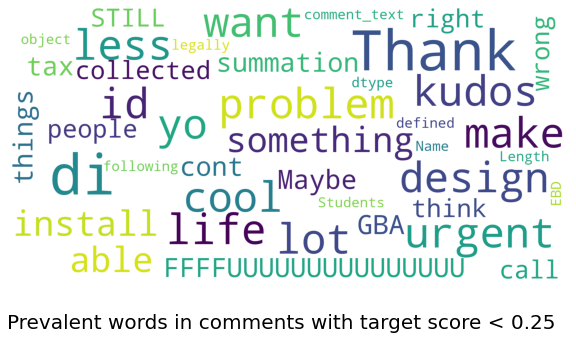

In [35]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

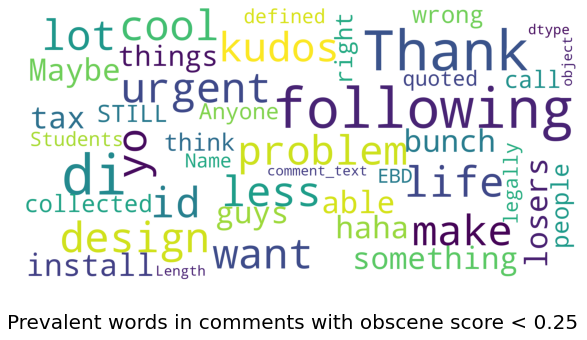

In [36]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

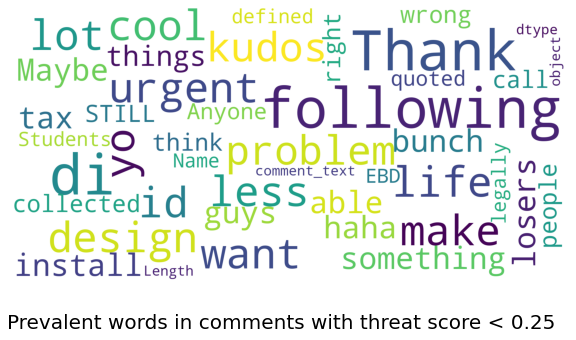

In [37]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

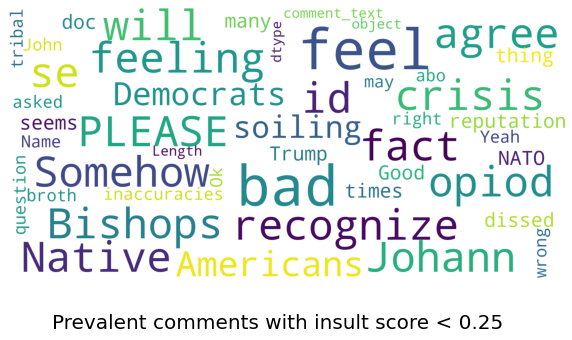

In [38]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')